In [1]:
!pip install underthesea


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 47.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.4/978.4 kB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.7 MB/s eta 0:00:00


In [2]:
import os, torch

os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["HF_HOME"] = "/kaggle/working/hf_cache"

DATA_DIR   = "/kaggle/input/uit-data-nhatnam5"
TRAIN_XLSX = os.path.join(DATA_DIR, "train_nor_811.xlsx")
VALID_XLSX = os.path.join(DATA_DIR, "valid_nor_811.xlsx")
TEST_XLSX  = os.path.join(DATA_DIR, "test_nor_811.xlsx")

OUT_DIR   = "/kaggle/working/outputs_phobert_vsmec"
PLOTS_DIR = os.path.join(OUT_DIR, "plots")
BEST_DIR  = os.path.join(OUT_DIR, "best_model")
CACHE_DIR = os.path.join(OUT_DIR, "cache")

for d in [OUT_DIR, PLOTS_DIR, BEST_DIR, CACHE_DIR]:
    os.makedirs(d, exist_ok=True)

print("GPUs:", torch.cuda.device_count())
print("Files exist:", os.path.exists(TRAIN_XLSX), os.path.exists(VALID_XLSX), os.path.exists(TEST_XLSX))

GPUs: 2
Files exist: True True True


In [3]:
import re, json, unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from underthesea import word_tokenize
from datasets import Dataset

from sklearn.metrics import (
    f1_score, accuracy_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)

from transformers import (
    AutoTokenizer, AutoConfig, AutoModelForSequenceClassification,
    DataCollatorWithPadding, TrainingArguments, Trainer, set_seed
)
#from accelerate import notebook_launcher

# Regex & chuẩn hoá
URL_RE = re.compile(r"(https?://\S+|www\.\S+)")
MULTISPACE_RE = re.compile(r"\s+")

def normalize_text(text: str) -> str:
    if text is None:
        return ""
    text = unicodedata.normalize("NFC", str(text))
    text = URL_RE.sub(" <url> ", text)
    text = MULTISPACE_RE.sub(" ", text).strip()
    return text

def underthesea_segment(text: str) -> str:
    text = normalize_text(text)
    if not text:
        return text
    try:
        seg = word_tokenize(text, format="text")
        if isinstance(seg, list):
            seg = " ".join(seg)
        return MULTISPACE_RE.sub(" ", seg).strip()
    except Exception:
        return text

def read_xlsx(path: str) -> pd.DataFrame:
    return pd.read_excel(path, engine="openpyxl")

def detect_cols(df: pd.DataFrame):
    cols_lower = [c.lower() for c in df.columns]
    text_candidates  = ["sentence","text","comment","content","review","utterance"]
    label_candidates = ["emotion","label","labels","class","category"]

    text_col = next((df.columns[i] for i,c in enumerate(cols_lower) if c in text_candidates), None)
    label_col = next((df.columns[i] for i,c in enumerate(cols_lower) if c in label_candidates), None)

    if text_col is None:
        obj_cols = [c for c in df.columns if df[c].dtype == "object"]
        avg_len = {c: df[c].astype(str).str.len().mean() for c in obj_cols}
        text_col = max(avg_len, key=avg_len.get)

    if label_col is None:
        cand = []
        for c in df.columns:
            if df[c].dtype == "object":
                nunq = df[c].nunique()
                if 2 <= nunq <= 50:
                    cand.append((c, nunq))
        label_col = sorted(cand, key=lambda x: x[1])[0][0]

    return text_col, label_col

def prep_df(df: pd.DataFrame, text_col: str, label_col: str) -> pd.DataFrame:
    out = df[[text_col, label_col]].copy()
    out.columns = ["text", "label"]
    out["text"]  = out["text"].astype(str)
    out["label"] = out["label"].astype(str)
    return out

def segment_with_cache(df: pd.DataFrame, split_name: str) -> pd.DataFrame:
    cache_path = os.path.join(CACHE_DIR, f"{split_name}_seg.csv")
    if os.path.exists(cache_path):
        cached = pd.read_csv(cache_path)
        if len(cached) == len(df) and "text_seg" in cached.columns:
            df = df.copy()
            df["text_seg"] = cached["text_seg"].astype(str)
            print(f"Loaded cache: {cache_path}")
            return df

    df = df.copy()
    segged = []
    for t in tqdm(df["text"].tolist(), desc=f"Underthesea segment {split_name}"):
        segged.append(underthesea_segment(t))
    df["text_seg"] = segged

    pd.DataFrame({"text_seg": df["text_seg"]}).to_csv(cache_path, index=False)
    print(f"Saved cache: {cache_path}")
    return df

# Plot phân bố nhãn
def plot_label_distribution(df: pd.DataFrame, split_name: str, label_list, out_dir: str):
    os.makedirs(out_dir, exist_ok=True)
    counts = df["label"].value_counts().reindex(label_list, fill_value=0)

    plt.figure(figsize=(8, 4))
    plt.bar(counts.index, counts.values)
    plt.title(f"Label distribution - {split_name}")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    out_path = os.path.join(out_dir, f"label_dist_{split_name}.png")
    plt.savefig(out_path)
    plt.show()
    plt.close()

    print(f"✅ Saved label distribution for {split_name} to:", out_path)

# Metrics cho Trainer
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": float(accuracy_score(labels, preds)),
        "macro_f1": float(f1_score(labels, preds, average="macro", zero_division=0)),
        "weighted_f1": float(f1_score(labels, preds, average="weighted", zero_division=0)),
    }

# Plot loss / metrics
def plot_curves(log_history, out_dir):
    os.makedirs(out_dir, exist_ok=True)

    train_steps, train_loss = [], []
    eval_epochs, eval_loss = [], []
    eval_acc, eval_macro, eval_weighted = [], [], []

    for item in log_history:
        if "loss" in item and "eval_loss" not in item:
            train_steps.append(item.get("step", len(train_steps)+1))
            train_loss.append(item["loss"])
        if "eval_loss" in item:
            eval_epochs.append(item.get("epoch", len(eval_epochs)+1))
            eval_loss.append(item["eval_loss"])
            eval_acc.append(item.get("eval_accuracy"))
            eval_macro.append(item.get("eval_macro_f1"))
            eval_weighted.append(item.get("eval_weighted_f1"))

    # Training loss
    plt.figure()
    if train_loss:
        plt.plot(train_steps, train_loss, label="train_loss")
    plt.xlabel("step"); plt.ylabel("loss"); plt.title("Training loss")
    plt.legend(); plt.tight_layout()
    train_loss_path = os.path.join(out_dir, "train_loss.png")
    plt.savefig(train_loss_path)
    plt.show()
    plt.close()

    # Eval loss
    plt.figure()
    if eval_loss:
        plt.plot(eval_epochs, eval_loss, label="eval_loss")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Eval loss")
    plt.legend(); plt.tight_layout()
    eval_loss_path = os.path.join(out_dir, "eval_loss.png")
    plt.savefig(eval_loss_path)
    plt.show()
    plt.close()

    # Eval metrics
    plt.figure()
    if any(v is not None for v in eval_acc):
        plt.plot(eval_epochs, eval_acc, label="eval_accuracy")
    if any(v is not None for v in eval_macro):
        plt.plot(eval_epochs, eval_macro, label="eval_macro_f1")
    if any(v is not None for v in eval_weighted):
        plt.plot(eval_epochs, eval_weighted, label="eval_weighted_f1")
    plt.xlabel("epoch"); plt.ylabel("score"); plt.title("Eval metrics")
    plt.legend(); plt.tight_layout()
    eval_metrics_path = os.path.join(out_dir, "eval_metrics.png")
    plt.savefig(eval_metrics_path)
    plt.show()
    plt.close()

# Confusion matrix
def plot_confmat_normalized(y_true, y_pred, labels, out_path):
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    plt.figure(figsize=(8,8))
    disp.plot(values_format=".2f", cmap=None, ax=plt.gca(), colorbar=True)
    plt.title("Normalized Confusion Matrix (normalize=true)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(out_path)
    plt.show()
    plt.close()

# Per-class F1
def plot_per_class_f1(y_true, y_pred, labels, out_path):
    f1s = f1_score(y_true, y_pred, average=None, zero_division=0)
    plt.figure(figsize=(10,4))
    plt.bar(labels, f1s)
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0, 1.0)
    plt.title("Per-class F1 (test)")
    plt.tight_layout()
    plt.savefig(out_path)
    plt.show()
    plt.close()

# Hàm infer 1 câu
@torch.inference_mode()
def infer(text, model, tokenizer, id2label, max_length=128, device=None):
    model.eval()
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    seg = underthesea_segment(text)
    inp = tokenizer(seg, truncation=True, max_length=max_length, return_tensors="pt").to(device)
    out = model(**inp)
    probs = torch.softmax(out.logits, dim=-1).squeeze(0).detach().cpu().numpy()
    pred_id = int(np.argmax(probs))
    return {
        "input": text,
        "segmented": seg,
        "pred_label": id2label[pred_id],
        "probs": {id2label[i]: float(probs[i]) for i in range(len(probs))}
    }

# Hàm in các mẫu dự đoán sai
def check_wrong(df: pd.DataFrame, n: int = 20, show_seg: bool = False, random: bool = False):
    """
    In ra các mẫu dự đoán sai theo format:
    <text>
    Predicted: (X) --vs-- Real label: (Y)
    --------------------------------------------------
    """
    wrong = df[df["is_correct"] == False]

    if wrong.empty:
        print("✅ Không có mẫu nào bị dự đoán sai.")
        return

    if random:
        wrong = wrong.sample(min(n, len(wrong)), random_state=42)
    else:
        wrong = wrong.head(n)

    for _, row in wrong.iterrows():
        if show_seg and "text_seg" in row:
            text_show = row["text_seg"]
        else:
            text_show = row["text"]

        print(text_show)
        print(f"Predicted: ({row['pred_label']}) --vs-- Real label: ({row['label']})")
        print("-" * 50)


2025-12-18 14:08:04.241577: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766066884.432126      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766066884.483467      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766066884.947353      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766066884.947387      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766066884.947390      55 computation_placer.cc:177] computation placer alr

Detected columns -> text: Sentence | label: Emotion
Sizes: 5548 686 693


,text,label
0,cho mình xin bài nhạc tên là gì với ạ,Other
1,cho đáng đời con quỷ . về nhà lôi con nhà mày ...,Disgust
2,lo học đi . yêu đương lol gì hay lại thích học...,Disgust
3,uớc gì sau này về già vẫn có thể như cụ này :)),Enjoyment
4,mỗi lần có video của con là cứ coi đi coi lại ...,Enjoyment


Underthesea segment train:   0%|          | 0/5548 [00:00<?, ?it/s]

Saved cache: /kaggle/working/outputs_phobert_vsmec/cache/train_seg.csv


Underthesea segment valid:   0%|          | 0/686 [00:00<?, ?it/s]

Saved cache: /kaggle/working/outputs_phobert_vsmec/cache/valid_seg.csv


Underthesea segment test:   0%|          | 0/693 [00:00<?, ?it/s]

Saved cache: /kaggle/working/outputs_phobert_vsmec/cache/test_seg.csv
Labels: ['Anger', 'Disgust', 'Enjoyment', 'Fear', 'Other', 'Sadness', 'Surprise']


,text,label,labels,text_seg
0,cho mình xin bài nhạc tên là gì với ạ,Other,4,cho mình xin bài nhạc tên là gì với ạ
1,cho đáng đời con quỷ . về nhà lôi con nhà mày ...,Disgust,1,cho đáng đời con quỷ . về nhà lôi con nhà mày ...
2,lo học đi . yêu đương lol gì hay lại thích học...,Disgust,1,lo học đi . yêu đương_lol gì hay lại thích học...
3,uớc gì sau này về già vẫn có thể như cụ này :)),Enjoyment,2,ước gì sau_này về già vẫn có_thể như cụ này :))
4,mỗi lần có video của con là cứ coi đi coi lại ...,Enjoyment,2,mỗi lần có video của con là cứ coi đi coi lại ...


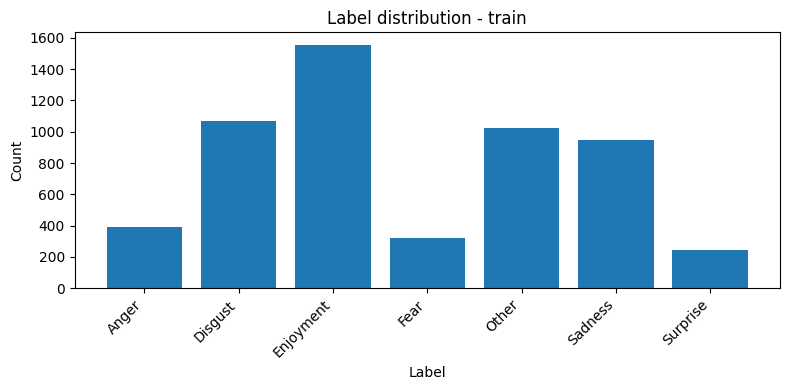

✅ Saved label distribution for train to: /kaggle/working/outputs_phobert_vsmec/plots/label_dist_train.png


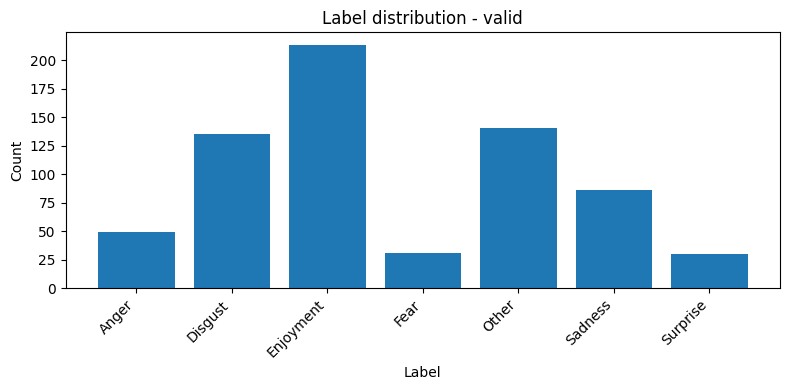

✅ Saved label distribution for valid to: /kaggle/working/outputs_phobert_vsmec/plots/label_dist_valid.png


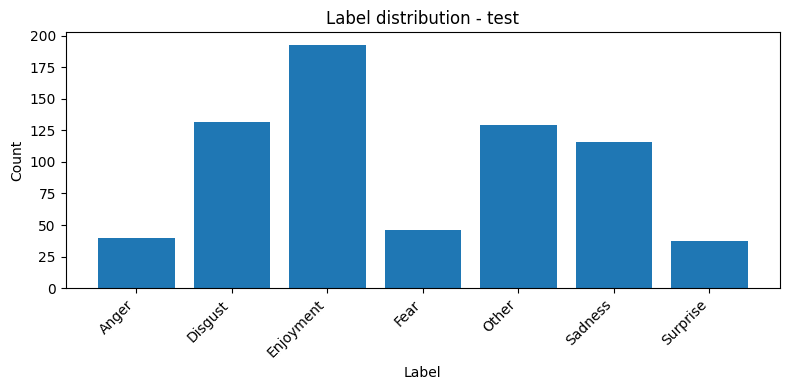

✅ Saved label distribution for test to: /kaggle/working/outputs_phobert_vsmec/plots/label_dist_test.png


In [4]:
# Đọc dữ liệu gốc
train_raw = read_xlsx(TRAIN_XLSX)
valid_raw = read_xlsx(VALID_XLSX)
test_raw  = read_xlsx(TEST_XLSX)

# Tự động detect cột text / label
text_col, label_col = detect_cols(train_raw)
print("Detected columns -> text:", text_col, "| label:", label_col)

# Chuẩn hoá về 2 cột: text, label
train_df = prep_df(train_raw, text_col, label_col)
valid_df = prep_df(valid_raw, text_col, label_col)
test_df  = prep_df(test_raw,  text_col, label_col)

print("Sizes:", len(train_df), len(valid_df), len(test_df))
display(train_df.head())

# Mapping nhãn
label_list = sorted(train_df["label"].unique().tolist())
label2id = {l:i for i,l in enumerate(label_list)}
id2label = {i:l for l,i in label2id.items()}

for df in [train_df, valid_df, test_df]:
    df["labels"] = df["label"].map(label2id)

# Segmentation + cache
train_df = segment_with_cache(train_df, "train")
valid_df = segment_with_cache(valid_df, "valid")
test_df  = segment_with_cache(test_df,  "test")

print("Labels:", label_list)
display(train_df.head())

# Plot phân bố nhãn
plot_label_distribution(train_df, "train", label_list, PLOTS_DIR)
plot_label_distribution(valid_df, "valid", label_list, PLOTS_DIR)
plot_label_distribution(test_df,  "test",  label_list, PLOTS_DIR)


In [5]:
MODEL_NAME = "vinai/phobert-base"
MAX_LEN = 128

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)

ds_train = Dataset.from_pandas(train_df[["text_seg","labels"]], preserve_index=False)
ds_valid = Dataset.from_pandas(valid_df[["text_seg","labels"]], preserve_index=False)
ds_test  = Dataset.from_pandas(test_df[["text_seg","labels"]],  preserve_index=False)

def tok_map(batch):
    return tokenizer(batch["text_seg"], truncation=True, max_length=MAX_LEN)

ds_train_tok = ds_train.map(tok_map, batched=True, remove_columns=["text_seg"], desc="Tokenize train")
ds_valid_tok = ds_valid.map(tok_map, batched=True, remove_columns=["text_seg"], desc="Tokenize valid")
ds_test_tok  = ds_test.map(tok_map,  batched=True, remove_columns=["text_seg"], desc="Tokenize test")

collator = DataCollatorWithPadding(tokenizer=tokenizer)
ds_train_tok


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Tokenize train:   0%|          | 0/5548 [00:00<?, ? examples/s]

Tokenize valid:   0%|          | 0/686 [00:00<?, ? examples/s]

Tokenize test:   0%|          | 0/693 [00:00<?, ? examples/s]

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 5548
})

In [6]:
SEED = 42
set_seed(SEED)

EPOCHS = 20
PER_DEVICE_BS = 16
GRAD_ACCUM = 2
LR = 2e-5

WEIGHT_DECAY = 0.02
LABEL_SMOOTH = 0.10
DROPOUT = 0.20
WARMUP_RATIO = 0.06
MAX_GRAD_NORM = 1.0

config = AutoConfig.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_list),
    label2id=label2id,
    id2label=id2label,
)
if hasattr(config, "hidden_dropout_prob"):
    config.hidden_dropout_prob = DROPOUT
if hasattr(config, "attention_probs_dropout_prob"):
    config.attention_probs_dropout_prob = DROPOUT

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)

training_args = TrainingArguments(
    output_dir=OUT_DIR,
    overwrite_output_dir=True,

    num_train_epochs=EPOCHS,
    per_device_train_batch_size=PER_DEVICE_BS,
    per_device_eval_batch_size=PER_DEVICE_BS,
    gradient_accumulation_steps=GRAD_ACCUM,

    learning_rate=LR,
    weight_decay=WEIGHT_DECAY,
    warmup_ratio=WARMUP_RATIO,
    lr_scheduler_type="cosine",

    eval_strategy="epoch",          # giữ nguyên logic của bạn
    save_strategy="epoch",
    save_total_limit=2,

    logging_strategy="steps",
    logging_steps=50,

    label_smoothing_factor=LABEL_SMOOTH,
    max_grad_norm=MAX_GRAD_NORM,

    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,

    fp16=torch.cuda.is_available(),
    report_to="none",
    seed=SEED,

    ddp_find_unused_parameters=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train_tok,
    eval_dataset=ds_valid_tok,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
)

print("Trainer ready.")


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_55/3048832213.py:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Trainer ready.


In [7]:
# Train
trainer.train()

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.904200,1.766068,0.309038,0.067981,0.148449
2,1.769100,1.561728,0.475219,0.250934,0.392036
3,1.544000,1.399730,0.539359,0.314820,0.483750
4,1.428300,1.331002,0.574344,0.426169,0.538686
5,1.297100,1.285309,0.584548,0.475234,0.568836
6,1.201300,1.282597,0.599125,0.499937,0.581882
7,1.135600,1.265237,0.600583,0.532672,0.595642
8,1.099800,1.294727,0.606414,0.550847,0.600929
9,1.041400,1.320532,0.591837,0.529245,0.584603
10,0.982800,1.291768,0.612245,0.552250,0.607602


TrainOutput(global_step=1740, training_loss=1.0917316480614674, metrics={'train_runtime': 977.7356, 'train_samples_per_second': 113.487, 'train_steps_per_second': 1.78, 'total_flos': 2741464819472400.0, 'train_loss': 1.0917316480614674, 'epoch': 20.0})

=== TEST SUMMARY ===
Accuracy    : 0.645
Macro F1    : 0.6205
Weighted F1 : 0.642

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

       Anger     0.4146    0.4250    0.4198        40
     Disgust     0.6518    0.5530    0.5984       132
   Enjoyment     0.7264    0.7565    0.7411       193
        Fear     0.6596    0.6739    0.6667        46
       Other     0.5841    0.5116    0.5455       129
     Sadness     0.6224    0.7672    0.6873       116
    Surprise     0.6944    0.6757    0.6849        37

    accuracy                         0.6450       693
   macro avg     0.6219    0.6233    0.6205       693
weighted avg     0.6441    0.6450    0.6420       693


=== VÍ DỤ DỰ ĐOÁN SAI (test) ===
người ta có bạn bè nhìn vui thật
Predicted: (Enjoyment) --vs-- Real label: (Sadness)
--------------------------------------------------
cho nghỉ viêc mói đúng sao goi là kỷ luật
Predicted: (Anger) --vs-- Real label: (Surprise)
-----------------------------

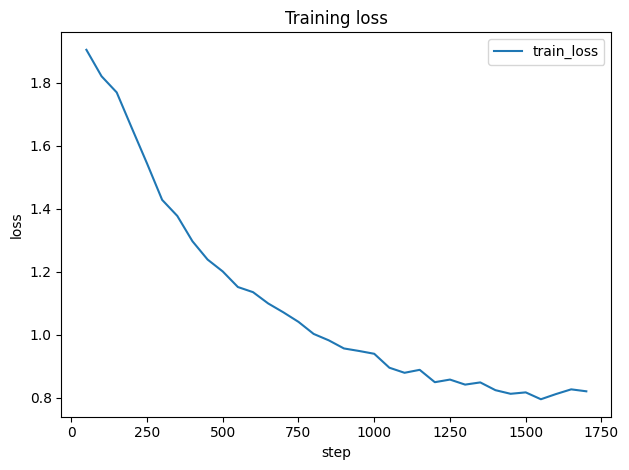

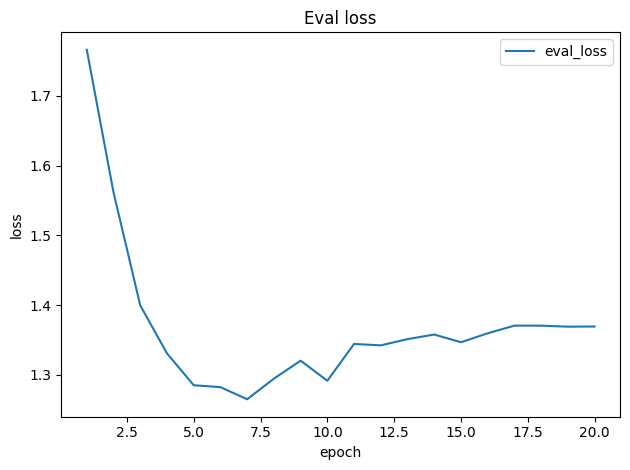

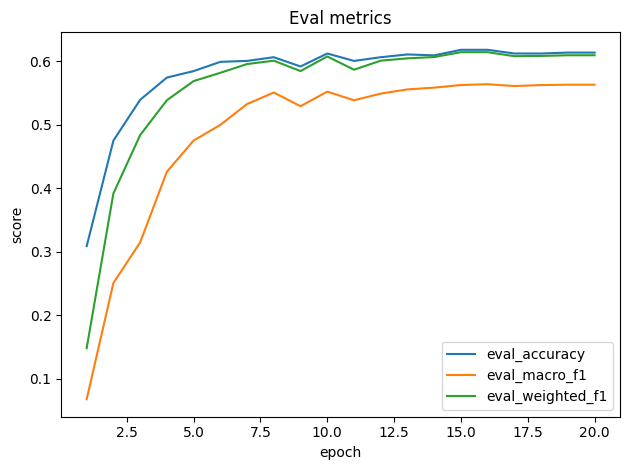

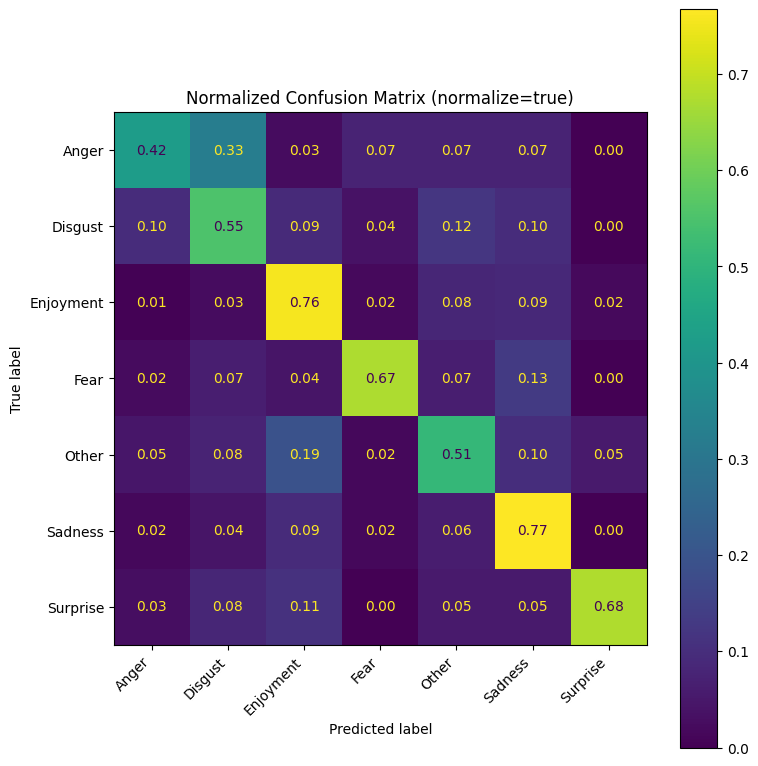

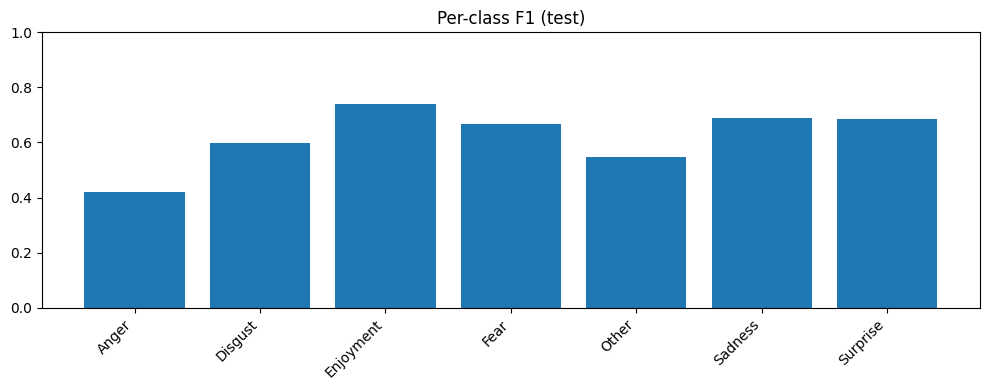

✅ Plots saved to: /kaggle/working/outputs_phobert_vsmec/plots


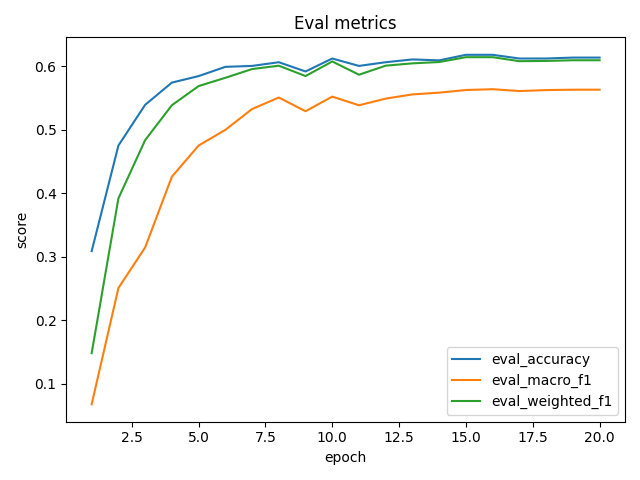

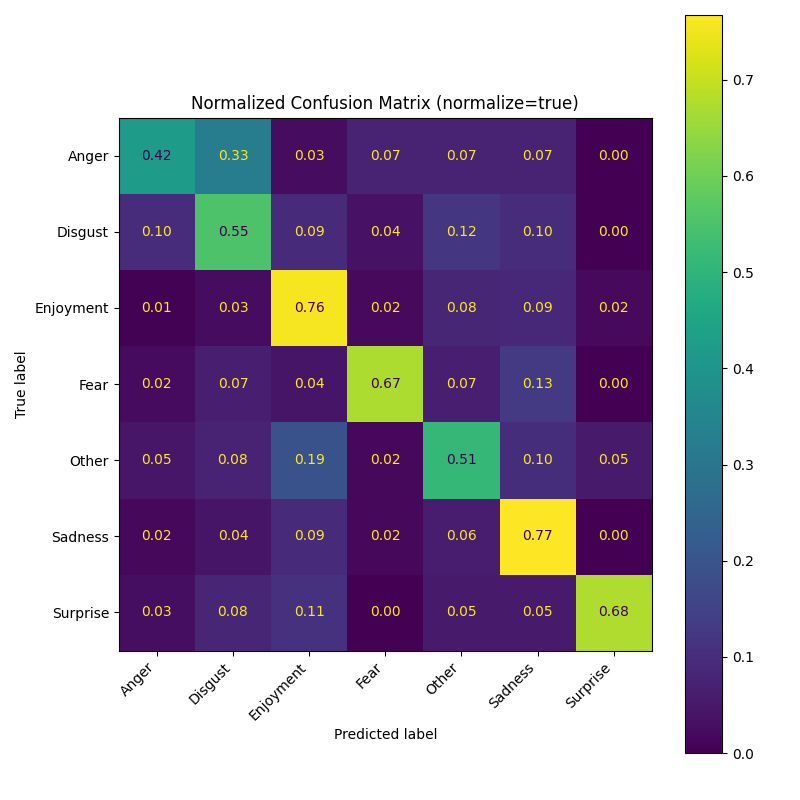

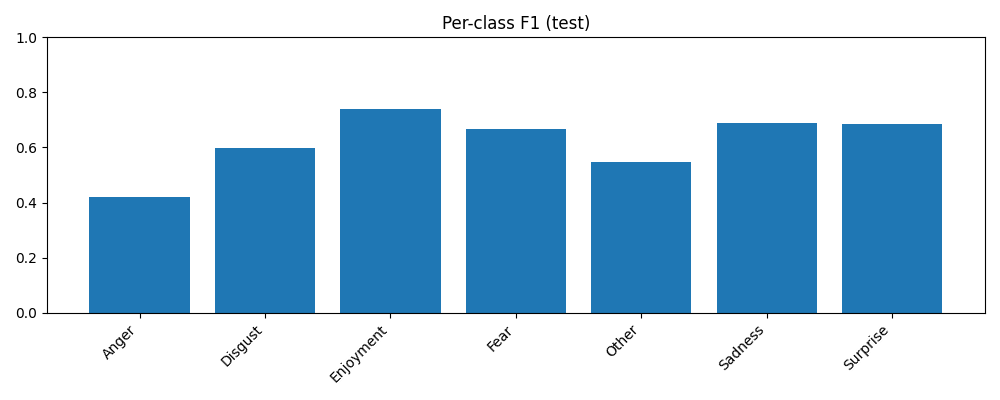

In [8]:
# Predict trên test
pred = trainer.predict(ds_test_tok)
y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=-1)

print("=== TEST SUMMARY ===")
print("Accuracy    :", round(accuracy_score(y_true, y_pred), 4))
print("Macro F1    :", round(f1_score(y_true, y_pred, average="macro", zero_division=0), 4))
print("Weighted F1 :", round(f1_score(y_true, y_pred, average="weighted", zero_division=0), 4))

print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_true, y_pred, target_names=label_list, digits=4, zero_division=0))

# Gắn dự đoán vào test_df để phân tích lỗi
test_df["pred_id"] = y_pred
test_df["pred_label"] = test_df["pred_id"].map(id2label)
test_df["is_correct"] = test_df["pred_label"] == test_df["label"]

print("\n=== VÍ DỤ DỰ ĐOÁN SAI (test) ===")
check_wrong(test_df, n=20, show_seg=False, random=False)

# Lưu model tốt nhất
trainer.save_model(BEST_DIR)
tokenizer.save_pretrained(BEST_DIR)
with open(os.path.join(BEST_DIR, "labels.json"), "w", encoding="utf-8") as f:
    json.dump({"label_list": label_list, "label2id": label2id, "id2label": id2label},
              f, ensure_ascii=False, indent=2)

print("✅ Saved best model to:", BEST_DIR)

# Vẽ & hiển thị các plot sau train
plot_curves(trainer.state.log_history, PLOTS_DIR)
plot_confmat_normalized(y_true, y_pred, label_list, os.path.join(PLOTS_DIR, "confmat_normalized.png"))
plot_per_class_f1(y_true, y_pred, label_list, os.path.join(PLOTS_DIR, "per_class_f1.png"))

print("✅ Plots saved to:", PLOTS_DIR)

from PIL import Image
from IPython.display import display

display(Image.open(os.path.join(PLOTS_DIR, "eval_metrics.png")))
display(Image.open(os.path.join(PLOTS_DIR, "confmat_normalized.png")))
display(Image.open(os.path.join(PLOTS_DIR, "per_class_f1.png")))


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
trainer.model.to(device)

demo = infer(
    "phấn chấn lên nào bro, ở đây có ae, không phải lo",
    trainer.model,
    tokenizer,
    id2label,
    max_length=MAX_LEN,
    device=device,
)
print(json.dumps(demo, ensure_ascii=False, indent=2))


{
  "input": "phấn chấn lên nào bro, ở đây có ae, không phải lo",
  "segmented": "phấn chấn lên nào bro , ở đây có ae , không phải lo",
  "pred_label": "Enjoyment",
  "probs": {
    "Anger": 0.015468701720237732,
    "Disgust": 0.018421921879053116,
    "Enjoyment": 0.7055870294570923,
    "Fear": 0.0561232715845108,
    "Other": 0.17404258251190186,
    "Sadness": 0.017385587096214294,
    "Surprise": 0.012970894575119019
  }
}


In [12]:
import shutil
import os

# Thư mục chứa model tốt nhất
print("BEST_DIR:", BEST_DIR)

zip_path = "/kaggle/working/phobert_vsmec_best_model"  # đường dẫn không có .zip
shutil.make_archive(zip_path, "zip", BEST_DIR)

print("✅ Đã tạo file:", zip_path + ".zip")


BEST_DIR: /kaggle/working/outputs_phobert_vsmec/best_model
✅ Đã tạo file: /kaggle/working/phobert_vsmec_best_model.zip
